# Upper-Body Sitting Posture Recognition Using Skeletal Keypoints

**Graduation Project – Machine Learning Module**

This notebook presents the data preprocessing, feature selection, model training, and evaluation process for upper-body sitting posture recognition using skeletal keypoints extracted via MediaPipe Pose.

**Dataset:** MultiPosture Dataset (IEEE Access, 2024)  
**Model:** XGBoost Classifier  
**Task:** Multi-class classification (Upper Body Posture)

---


## 1. Introduction

Monitoring sitting posture is an important component of ergonomic assessment and attention-aware systems. In this work, we focus on recognizing upper-body sitting postures using skeletal joint keypoints extracted from a single RGB camera.

Instead of relying on raw images or video streams, the system utilizes normalized 3D skeletal coordinates obtained using MediaPipe Pose. This approach preserves user privacy while enabling accurate posture classification.

The objective of this notebook is to:
- Analyze the posture dataset
- Select relevant upper-body features
- Train and evaluate machine learning models
- Validate model stability and robustness
- Produce a final trained model suitable for real-time deployment


## 2. Dataset Description

The experiments are conducted using the **MultiPosture dataset**, published in *IEEE Access (2024)*.  
This dataset was designed for multi-task sitting posture recognition and contains skeletal pose data extracted using the MediaPipe Pose Heavy model.

The data was collected from **13 participants** performing various sitting postures in home environments.  
To preserve privacy, the dataset includes only processed skeletal joint coordinates, without any raw images or video recordings.


### 2.1 Dataset Characteristics

Each frame in the dataset consists of:
- 3D skeletal coordinates (x, y, z)
- 11 key body joints
- Coordinates normalized relative to the hip center
- A total of 33 input features per frame

The dataset contains approximately **4,800 labeled frames**, with each frame manually annotated and validated by experts.


### 2.2 Posture Labels

The dataset provides posture annotations for both upper-body and lower-body sitting postures.

**Upper Body Posture Classes:**
- TUP: Upright trunk position
- TLB: Trunk leaning backward
- TLF: Trunk leaning forward
- TLR: Trunk leaning right
- TLL: Trunk leaning left

**Lower Body Posture Classes:**
- LAP: Legs apart
- LWA: Legs wide apart
- LCS: Legs closed
- LCR: Legs crossed (right over left)
- LCL: Legs crossed (left over right)
- LLR: Legs lateral right
- LLL: Legs lateral left


### 2.3 Scope of This Work

Although the dataset supports both upper-body and lower-body posture recognition, this work focuses exclusively on **upper-body posture classification**.

This design choice was motivated by the following reasons:
- Upper-body posture is the primary indicator of trunk alignment and ergonomic sitting behavior.
- Upper-body joints are more reliably detected using a single RGB camera.
- The real-time desktop camera application implemented in this project operates on upper-body skeletal landmarks only.

Lower-body posture recognition is considered out of scope for this phase and is proposed as future work.


### Environment Setup & Imports

In [20]:
# ==========================
# 1) Imports & Environment Setup
# ==========================

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

print("Environment ready ✔️")


Environment ready ✔️


### Load Dataset

In [21]:
# ==========================
# 2) Load Dataset
# ==========================

df = pd.read_csv("data.csv")

print("Shape:", df.shape)
df.head()


Shape: (4794, 102)


,subject,upperbody_label,lowerbody_label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1,TLB,LCL,0.013146,-0.534424,-0.176213,0.019678,-0.557297,-0.160404,0.021779,...,-0.313284,-0.074499,0.623198,-0.041134,-0.362046,0.284611,-0.416112,-0.083041,0.690973,-0.153205
1,1,TLB,LCL,-0.027462,-0.499347,-0.235089,-0.013835,-0.522232,-0.217069,-0.012026,...,-0.339221,0.018673,0.683186,-0.037659,-0.247262,0.340290,-0.444570,0.034586,0.751673,-0.148952
2,1,TLB,LCL,-0.017639,-0.542063,-0.223344,-0.000430,-0.562522,-0.202060,0.001764,...,-0.243208,0.049054,0.677385,-0.036760,-0.249142,0.455043,-0.314104,0.051902,0.745649,-0.125802
3,1,TLB,LCL,-0.027630,-0.556502,-0.149826,-0.007174,-0.575659,-0.129025,-0.005589,...,-0.306242,0.065110,0.672955,0.004685,-0.261612,0.440069,-0.395166,0.057489,0.747611,-0.082085
4,1,TLB,LCL,-0.033802,-0.556527,-0.174968,-0.012644,-0.575930,-0.154702,-0.011082,...,-0.310197,0.063744,0.668368,0.012122,-0.265350,0.453247,-0.398636,0.061104,0.747678,-0.075673


## 3. Data Integrity Verification

Before training the models, the dataset was inspected to ensure data quality.
The following checks were performed:
- Missing values
- Duplicate samples
- Column consistency


### Check Columns / Nulls / Duplicates

In [22]:
print("===== Dataset Columns =====")
print(df.columns.tolist())

print("\n===== Missing Values Check =====")
print(df.isnull().sum())

print("\n===== Duplicate Rows Check =====")
print("Number of duplicate rows:", df.duplicated().sum())


===== Dataset Columns =====
['subject', 'upperbody_label', 'lowerbody_label', 'nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x', 'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y', 'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y', 'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z', 'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y', 'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z', 'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_pinky_x', 'left_pinky_y', 'left_pinky_z', 'right_pin

The inspection confirms that the dataset is clean, with no missing values or duplicate samples.


## 4. Exploratory Data Analysis (EDA)

This section analyzes the distribution of posture labels to identify potential class imbalance.


====== Upper Body Distribution ======
upperbody_label
TLF    1897
TUP    1615
TLB     442
TLL     420
TLR     420
Name: count, dtype: int64

====== Lower Body Distribution ======
lowerbody_label
LAP    1153
LWA    1030
LCS     631
LCL     609
LCR     571
LLR     419
LLL     381
Name: count, dtype: int64


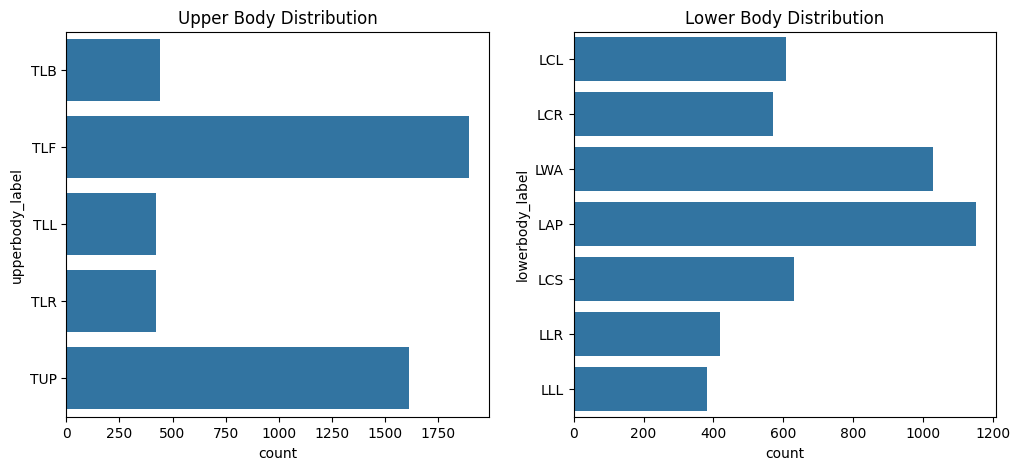

In [23]:
# ==========================
# 3) EDA — Label Distributions
# ==========================

print("====== Upper Body Distribution ======")
print(df["upperbody_label"].value_counts())

print("\n====== Lower Body Distribution ======")
print(df["lowerbody_label"].value_counts())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["upperbody_label"])
plt.title("Upper Body Distribution")

plt.subplot(1,2,2)
sns.countplot(df["lowerbody_label"])
plt.title("Lower Body Distribution")

plt.show()


The dataset exhibits moderate class imbalance, particularly in the upper-body posture classes.
This imbalance is addressed during model training using class weighting techniques.


### Compute Percentages

In [6]:
print("Upper Body Percentages:")
print((df["upperbody_label"].value_counts(normalize=True) * 100).round(2))

print("\nLower Body Percentages:")
print((df["lowerbody_label"].value_counts(normalize=True) * 100).round(2))


Upper Body Percentages:
upperbody_label
TLF    39.57
TUP    33.69
TLB     9.22
TLL     8.76
TLR     8.76
Name: proportion, dtype: float64

Lower Body Percentages:
lowerbody_label
LAP    24.05
LWA    21.49
LCS    13.16
LCL    12.70
LCR    11.91
LLR     8.74
LLL     7.95
Name: proportion, dtype: float64


Upper-body posture classes are dominated by forward-leaning (TLF) and upright (TUP) postures,
which together account for more than 70% of the dataset. This distribution motivates the
use of balanced training strategies.


## 5. Feature Selection

Only upper-body skeletal joints were selected to ensure compatibility with the real-time camera system.
The selected joints include facial landmarks and shoulder joints, which are most relevant for trunk posture estimation.


### Select Upper-Body Features Only (24 feature)

In [24]:
# ==========================
# 4) Select Core Upper-Body Features
# ==========================

core_joints = [
    "nose",
    "left_eye_inner","left_eye","left_eye_outer",
    "right_eye_inner","right_eye","right_eye_outer",
    "left_ear","right_ear",
    "mouth_left","mouth_right",
    "left_shoulder","right_shoulder"
]

axes = ["x", "y", "z"]

feature_cols = [f"{joint}_{axis}" for joint in core_joints for axis in axes]

print("Selected Features Count:", len(feature_cols))
print(feature_cols)

# إنشاء DataFrame جديد يحتوي فقط على الأعمدة المطلوبة
df_upper = df[["upperbody_label"] + feature_cols].copy()

print("\nNew df_upper Shape:", df_upper.shape)
df_upper.head()


Selected Features Count: 39
['nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x', 'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y', 'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y', 'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z', 'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y', 'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z', 'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z']

New df_upper Shape: (4794, 40)


,upperbody_label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,...,mouth_left_z,mouth_right_x,mouth_right_y,mouth_right_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z
0,TLB,0.013146,-0.534424,-0.176213,0.019678,-0.557297,-0.160404,0.021779,-0.557425,-0.149782,...,-0.121313,0.009431,-0.487613,-0.155437,0.150903,-0.410920,0.083537,-0.157582,-0.429711,0.076488
1,TLB,-0.027462,-0.499347,-0.235089,-0.013835,-0.522232,-0.217069,-0.012026,-0.523409,-0.207089,...,-0.175012,-0.027698,-0.456601,-0.200109,0.140897,-0.389582,0.061381,-0.190011,-0.416410,0.087674
2,TLB,-0.017639,-0.542063,-0.223344,-0.000430,-0.562522,-0.202060,0.001764,-0.564287,-0.192881,...,-0.163595,-0.019579,-0.497037,-0.189581,0.144089,-0.400014,0.059314,-0.184070,-0.433624,0.100442
3,TLB,-0.027630,-0.556502,-0.149826,-0.007174,-0.575659,-0.129025,-0.005589,-0.577449,-0.119257,...,-0.096257,-0.026295,-0.511223,-0.115317,0.144903,-0.402342,0.103447,-0.181436,-0.441268,0.164431
4,TLB,-0.033802,-0.556527,-0.174968,-0.012644,-0.575930,-0.154702,-0.011082,-0.577794,-0.145198,...,-0.120273,-0.030807,-0.511625,-0.139684,0.145551,-0.403466,0.084832,-0.179686,-0.445722,0.145164


## 6. Data Preprocessing

The preprocessing pipeline consists of:
- Label encoding of posture classes
- Train–test split with stratification
- Feature scaling using Min-Max normalization

Although tree-based models do not strictly require scaling, it was applied for consistency and potential extensibility.


### Preprocessing (LabelEncoder + Scaling + Split)

In [13]:
# ==========================
# 5) Preprocessing (Upper Body Only)
# ==========================

df_model = df_upper.copy()

# Features + Target
X = df_model.drop("upperbody_label", axis=1).values
y = df_model["upperbody_label"].values

# Label Encoding
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded
)

# Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Class Weights
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", label_enc.classes_)
print("Class Weights:", class_weights)


Train shape: (3835, 39)
Test shape: (959, 39)
Classes: ['TLB' 'TLF' 'TLL' 'TLR' 'TUP']
Class Weights: {0: np.float64(2.1666666666666665), 1: np.float64(0.5056031641397495), 2: np.float64(2.2827380952380953), 3: np.float64(2.2827380952380953), 4: np.float64(0.5936532507739938)}


## 7. Model Training

Two machine learning models were evaluated:
- Random Forest Classifier
- XGBoost Classifier

XGBoost was selected as the final model due to its superior performance,
robust handling of class imbalance, and stable behavior across multiple
evaluation runs.



#### Random Forest Model

In [14]:
# ==========================
# 6) Train Random Forest (Upper-Body Only)
# ==========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    class_weight=class_weights  # مهم جداً مع imbalance
)

rf.fit(X_train, y_train)

# التوقع
y_pred_rf = rf.predict(X_test)

# الدقة
acc_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", acc_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_enc.classes_))


Random Forest Accuracy: 0.9812304483837331

Classification Report:
              precision    recall  f1-score   support

         TLB       0.94      0.95      0.95        88
         TLF       0.99      0.99      0.99       380
         TLL       1.00      1.00      1.00        84
         TLR       1.00      1.00      1.00        84
         TUP       0.98      0.97      0.97       323

    accuracy                           0.98       959
   macro avg       0.98      0.98      0.98       959
weighted avg       0.98      0.98      0.98       959



#### XGBoost

In [15]:
# ==========================
# XGBoost Classifier
# ==========================
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# عدد الكلاسات نقرأه مباشرة من y_train
num_classes = len(np.unique(y_train))

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb, target_names=label_enc.classes_))


XGBoost Accuracy: 0.9874869655891554
              precision    recall  f1-score   support

         TLB       0.98      0.97      0.97        88
         TLF       0.99      0.99      0.99       380
         TLL       1.00      0.99      0.99        84
         TLR       1.00      1.00      1.00        84
         TUP       0.98      0.99      0.98       323

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959



## 8. Model Evaluation and Stability Analysis

To ensure that the reported accuracy is not the result of a favorable data split, multiple evaluation strategies were applied.


#### Repeated Train/Test Splits

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

acc_list = []

for seed in [0, 1, 2, 3, 4]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=seed,
        stratify=y_encoded
    )

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softmax",
        num_class=len(np.unique(y_train)),
        random_state=seed
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc_list.append(accuracy_score(y_test, y_pred))

print("Accuracies:", acc_list)
print("Mean Accuracy:", np.mean(acc_list))
print("Std:", np.std(acc_list))


Accuracies: [0.9927007299270073, 0.9947862356621481, 0.9906152241918665, 0.9937434827945777, 0.9927007299270073]
Mean Accuracy: 0.9929092805005213
Std: 0.0013833680043192475


#### Stratified K-Fold Cross Validation

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    xgb,
    X,
    y_encoded,
    cv=skf,
    scoring="accuracy"
)

print("CV Scores:", scores)
print("Mean CV Accuracy:", scores.mean())
print("Std:", scores.std())


CV Scores: [0.99270073 0.99270073 0.99165798 0.99165798 0.9874739 ]
Mean CV Accuracy: 0.9912382635878971
Std: 0.001939089360546284


The low standard deviation across repeated splits and cross-validation folds
indicates that the model performance is stable and not dependent on a specific
data partition, confirming the robustness of the proposed approach.


## 9. Final Model Training and Export

After completing all evaluation procedures, the final XGBoost model was
trained on the training set and saved for deployment in the real-time
desktop camera application.



In [16]:
import os
import pickle

# Create folder if not exists
os.makedirs("models", exist_ok=True)

# ============ Save XGBoost Model ============
with open("models/xgb_posture_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

# ============ Save Scaler ============
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# ============ Save Label Encoder ============
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(label_enc, f)

print("Saved: xgb_posture_model.pkl, scaler.pkl, label_encoder.pkl")


Saved: xgb_posture_model.pkl, scaler.pkl, label_encoder.pkl


## 10. Conclusion

This notebook demonstrated a complete machine learning pipeline for upper-body sitting posture recognition.
The proposed approach achieves high accuracy while maintaining privacy and real-time feasibility.

The trained model is integrated into a desktop camera application and serves as a core component of the Smart Posture and Attention Monitoring System.
